In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def first_view(df):
    """
    This function allows to check the variables name, and types.
    Additionaly it allows to check the percentage of null values for each variable

    input: dataframe to be queried
    """
    dtype=df.info()
    null_percentage=(df.isnull().sum() / df.shape[0] * 100)
    null_df = pd.DataFrame({'variable': null_percentage.index, 
                        'null_percentage': null_percentage.values})
    null_df.columns=[['variables', 'null_percentage']]
    return print(dtype, 
                 null_df)

### Dados de Satisfação - ELT ###

A tabela compartilhada é uma tabela de log, logo temos todos os registros de movimentação de determinado ticket. Como nosso objetivo é analisar tempo e avaliação do atendimento, é importante tratarmos a tabela garantido o último registro com os scores que nos interessam.

In [3]:
df_sat=pd.read_csv('tabela_satisfacao_log 5.csv', sep=';', usecols=[0,1,2])

In [4]:
first_view(df_sat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419089 entries, 0 to 419088
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ticket_id   416533 non-null  float64
 1   updated_at  416533 non-null  object 
 2   score       416533 non-null  object 
dtypes: float64(1), object(2)
memory usage: 9.6+ MB
None     variables null_percentage
0   ticket_id        0.609894
1  updated_at        0.609894
2       score        0.609894


In [5]:
df_sat=df_sat.loc[0:416532] #cleanning rows with NaN in all labels.

In [6]:
first_view(df_sat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416533 entries, 0 to 416532
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ticket_id   416533 non-null  float64
 1   updated_at  416533 non-null  object 
 2   score       416533 non-null  object 
dtypes: float64(1), object(2)
memory usage: 9.5+ MB
None     variables null_percentage
0   ticket_id             0.0
1  updated_at             0.0
2       score             0.0


In [7]:
df_sat['ticket_id']=df_sat['ticket_id'].astype('str').str[0:6] #id as string

In [8]:
df_sat['updated_at']=pd.to_datetime(df_sat['updated_at'].str[0:-8]) #normalize as datetime

In [9]:
# create a df with the lastest updated record without offered score
df_lastupdated=df_sat.groupby([df_sat.loc[df_sat['score']!='offered','ticket_id']]
                )['updated_at'].max().reset_index(name='updated_at')
# join the score according ticket_id and update_at
dfsat_lastupdate=df_lastupdated.merge(df_sat.loc[df_sat['score']!='offered'], 
                     on=['ticket_id', 'updated_at'],how='inner')

In [10]:
# total ticket 80149
dfsat_lastupdate.shape

(80149, 3)

In [11]:
# marjoity of the score is good
dfsat_lastupdate['score'].value_counts(normalize=True)

score
good    0.902656
bad     0.097344
Name: proportion, dtype: float64

Observamos nesta tabela que não temos valores e agora temos apenas o último registro de cada ticket aberto.

### Métricas - ETL ###

In [12]:
df_metricas=pd.read_csv('tabela_ticket_metricas 4.csv', sep=';')

In [13]:
first_view(df_metricas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120013 entries, 0 to 120012
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ticket_id          120013 non-null  int64 
 1   status             120013 non-null  object
 2   tempo_de_resposta  120013 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.7+ MB
None            variables null_percentage
0          ticket_id             0.0
1             status             0.0
2  tempo_de_resposta             0.0


Os dados não possuem NULL values

In [14]:
# the keys should have the same data type
df_metricas['ticket_id']=df_metricas['ticket_id'].astype('str')

In [15]:
# data doesn't have duplicity
df_metricas['ticket_id'].duplicated().value_counts()

ticket_id
False    120013
Name: count, dtype: int64

### Comparing Last_Updated table and Metricas table ##

In [16]:
# pct tickets from df_lastupdated are in df_metricas
df_lastupdated['ticket_id'].isin(
    df_metricas['ticket_id']).value_counts(normalize=True)

ticket_id
True     0.610513
False    0.389487
Name: proportion, dtype: float64

Como precisamos das informações referentes a tempo de atendimento, realizaremos um left join pois a tabela métricas possui mais observações que a tabela log.

In [17]:
#join the tables
final_data=dfsat_lastupdate.merge(df_metricas[['ticket_id','tempo_de_resposta']],
                     on='ticket_id',
                     how='left')

In [18]:
first_view(final_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80149 entries, 0 to 80148
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ticket_id          80149 non-null  object        
 1   updated_at         80149 non-null  datetime64[ns]
 2   score              80149 non-null  object        
 3   tempo_de_resposta  48932 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.4+ MB
None            variables null_percentage
0          ticket_id        0.000000
1         updated_at        0.000000
2              score        0.000000
3  tempo_de_resposta       38.948708


Observamos que 39% dos tickets não possuem a informação de tempo de resposta, como a solicitação é referente aos tickets com avaliação, proporemos ao time de negócio para que conduzamos uma análise destes sem resposta.

In [19]:
grouped_data=final_data.groupby(
    [final_data['updated_at'].dt.year])['tempo_de_resposta']
null_counts=grouped_data.apply(lambda x: x.isnull().sum())
non_null_counts=grouped_data.count()

pd.DataFrame({'year': null_counts.index,
             'null_count': null_counts.values,
             'non_null_count': non_null_counts.values})

,year,null_count,non_null_count
0,2016,8426,0
1,2017,10006,0
2,2018,9537,8691
3,2019,2690,32534
4,2020,558,7707


Quando obsevamos a quantidade de dados nulos em tempo de resposta por ano, observamos que os anos de 2016 e 2017 possuem apenas valores nulos, para esta análise apenas consideraremos as observações sem valores nulos.

### Análise com dados de tempo de resposta ###

A meta é a resoluçao dos chamados em até 3 dias (4320 minutos).
Tempo de resposta está em minutos



In [20]:
filtered_data=final_data['tempo_de_resposta'].notnull()
with_time_data=final_data[filtered_data].reset_index(drop=True)
with_time_data.tempo_de_resposta=with_time_data.tempo_de_resposta.astype('int')

with_time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48932 entries, 0 to 48931
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ticket_id          48932 non-null  object        
 1   updated_at         48932 non-null  datetime64[ns]
 2   score              48932 non-null  object        
 3   tempo_de_resposta  48932 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.5+ MB


In [21]:
# creating a variable to check if the answering time is greater than 3
#days
with_time_data['more_3days']=np.where(
    with_time_data['tempo_de_resposta']>4320, 1,0)

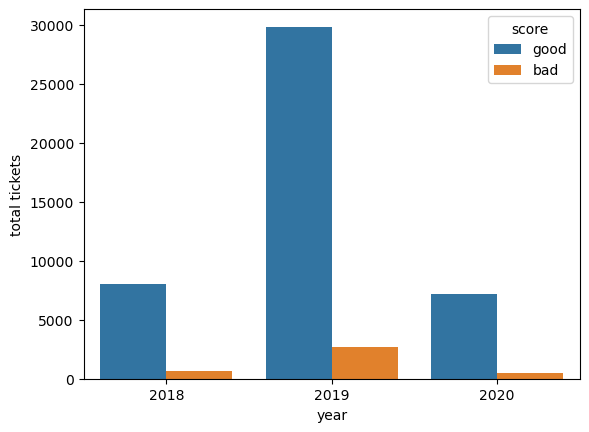

In [22]:
sns.countplot(
    data=with_time_data,
    x=with_time_data['updated_at'].dt.year,
    hue='score'
)
plt.xlabel('year')
plt.ylabel('total tickets');

Observamos que a maioria dos nossos tickets são do ano de 2019. 
Há alguma diferença nos chamados ao longo dos anos? Temos alguma sazionalidade mensal deles? 

In [23]:
with_time_data.groupby(
    [with_time_data['updated_at'].dt.year]
    )['score'].value_counts(normalize=True).reset_index()

,updated_at,score,proportion
0,2018,good,0.925325
1,2018,bad,0.074675
2,2019,good,0.917625
3,2019,bad,0.082375
4,2020,good,0.935124
5,2020,bad,0.064876


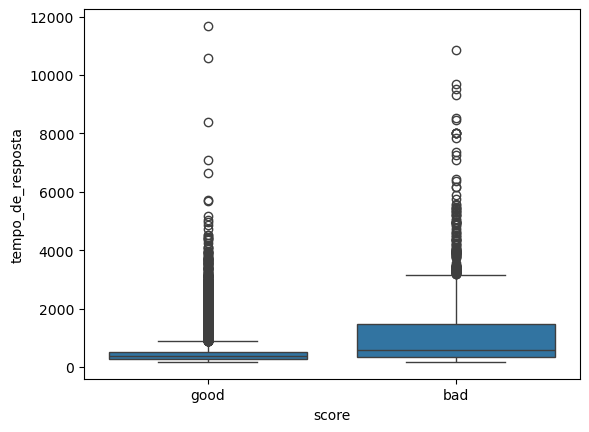

In [24]:
sns.boxplot(data=with_time_data, x='score',y='tempo_de_resposta');

* Good Score:
  - presença de outliers
  - outliers que puxam a média para cima
  - há pouca variabilidade em entre q1 e q3
* Bad Score:
  - presença de outliers
  - mediana de resposta maior do que a do score good
  - grande variabilidade entre q1 e q3 

In [25]:
with_time_data.groupby('score')['tempo_de_resposta'].describe()

,count,mean,std,min,25%,50%,75%,max
score,,,,,,,,
bad,3829.0,1049.890572,1038.144188,176.0,354.0,593.0,1489.0,10840.0
good,45103.0,465.806266,337.475504,176.0,281.0,387.0,530.0,11680.0


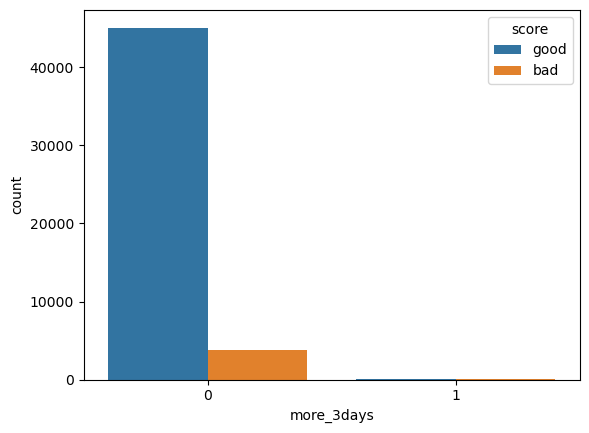

In [26]:
sns.countplot(data=with_time_data, x='more_3days',hue='score');

In [27]:
#checking pct of score when answering > 3days
with_time_data.loc[with_time_data['more_3days']==1,
  'score'].value_counts(normalize=True)

score
bad     0.75641
good    0.24359
Name: proportion, dtype: float64

Marjoritariamente os chamados são atendidos em menos de três dias, porém quando analisamos os chamados respondidos com mais de três dias notamos que a proporção de tickets avaliados com bad score é 3x maior em comparação com o good score

### Checking Percentile Visualization ###

In [28]:
quantiles = [p / 100 for p in range(10, 100, 10)]

quantile_values=with_time_data['tempo_de_resposta'].quantile(quantiles)
pd.DataFrame({'tempo_de_resposta': quantile_values}
            ).reset_index().rename(columns={'index':'percentile',
                                           'tempo_de_resposta':'pct_value'})

,percentile,pct_value
0,0.1,224.0
1,0.2,265.0
2,0.3,303.0
3,0.4,347.0
4,0.5,395.0
5,0.6,452.0
6,0.7,512.0
7,0.8,603.0
8,0.9,854.0


In [29]:
def classify_percentiles(value):
    if 0<=value<224:
        return '0 a 224'
    elif 225<=value<265:
        return '225 a 265'
    elif 266<=value<303:
        return '266 a 303'
    elif 304<=value<347:
        return '304 a 347'
    elif 348<=value<395:
        return'348 a 395'
    elif 396<=value<452:
        return'396 a 452'
    elif 453<=value<512:
        return'453 a 512'
    elif 513<=value<603:
        return'513 a 603'
    elif 604<=value<854:
        return'604 a 854'
    else:
        return'> 855'

In [30]:
with_time_data['pct_range']=with_time_data['tempo_de_resposta'].apply(classify_percentiles)

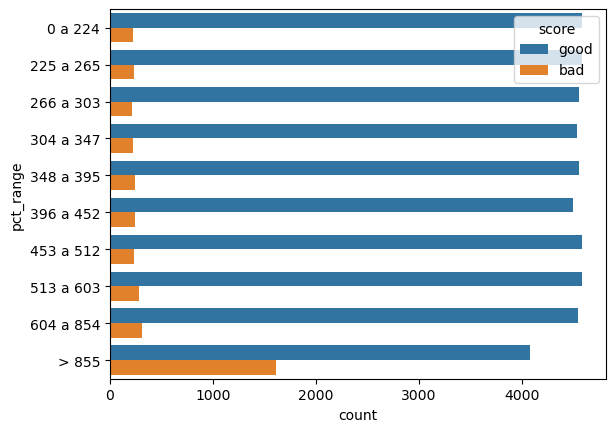

In [31]:
order=['0 a 224','225 a 265','266 a 303','304 a 347','348 a 395','396 a 452','453 a 512',
       '513 a 603','604 a 854','> 855']

sns.countplot(data=with_time_data, 
              y='pct_range', 
              hue='score',
             order = order);

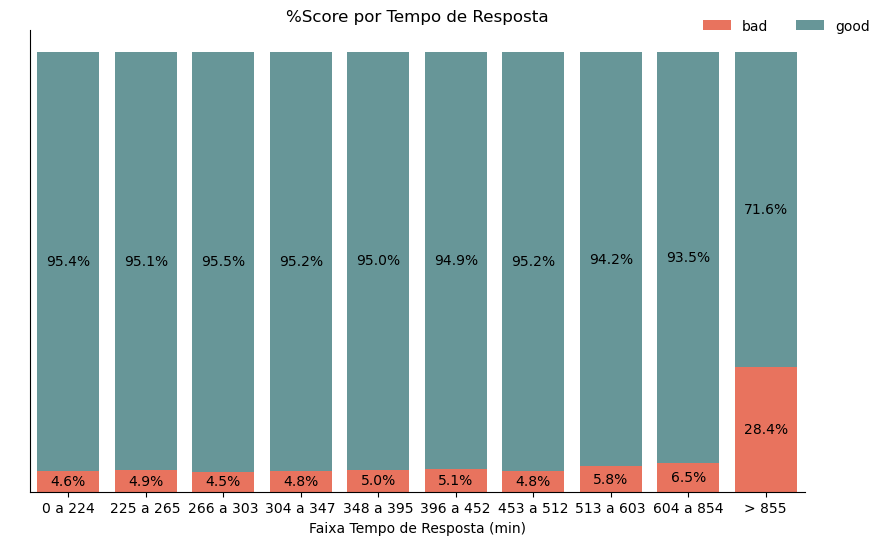

In [32]:
order=['0 a 224','225 a 265','266 a 303','304 a 347','348 a 395','396 a 452','453 a 512',
       '513 a 603','604 a 854','> 855']

def calculate_percentages(df, x_col, hue_col, order):
    """Calculates percentages for stacked bar chart."""
    total_counts = df.groupby(x_col)[hue_col].count().reindex(order, fill_value=0) #Reindex to ensure correct order and 0 fill
    grouped_counts = df.groupby([x_col, hue_col]).size().unstack(fill_value=0).reindex(order, fill_value=0) #Reindex to ensure correct order and 0 fill
    percentages = (grouped_counts.T / total_counts).T * 100
    return percentages

percentages = calculate_percentages(with_time_data, 'pct_range', 'score', order)

# 2. Create the stacked bar plot using sns.barplot:
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size if needed

bottom = None #Initialize for stacking
for hue_value, color in zip(['bad', 'good'], ['tomato', 'cadetblue']):
    sns.barplot(x=percentages.index, y=percentages[hue_value], color=color, ax=ax, label=hue_value, bottom=bottom)
    if bottom is None:
        bottom = percentages[hue_value]
    else:
        bottom += percentages[hue_value]

# 3. Add percentage labels above the stacked bars:
for p in ax.patches:
    height = p.get_height()
    if height > 0: #Avoid labels for 0 height bars.
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + height / 2  # Center vertically within the stack
        percentage = height #Height is already the percentage
        ax.text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black')  # Adjust color as needed

sns.despine()
plt.xlabel("Faixa Tempo de Resposta (min)") #Optional label
plt.ylabel(" ") #Optional label
plt.yticks(ticks=[])
plt.title("%Score por Tempo de Resposta") #Optional title
plt.legend(frameon=False, ncol=len(with_time_data.columns),bbox_to_anchor=(1.1, 1.05)) #Show legend if needed
plt.show()

Quando dividmos a quantidade de tickets avalidos em faixas de resposta (a da proporção entre bons e ruins em cada faixa é 100) observamos que a proporção de tickets avaliados negativamente cresce conforme o tempo para uma resposta aumenta

In [33]:
# creating a rank to sort the next lineplot
with_time_data['order_by_pct']=pd.Series()
with_time_data['order_by_pct']=np.where(with_time_data['pct_range']=='0 a 224', '01', with_time_data['order_by_pct'])
with_time_data['order_by_pct']=np.where(with_time_data['pct_range']=='225 a 265','02', with_time_data['order_by_pct'])
with_time_data['order_by_pct']=np.where(with_time_data['pct_range']=='266 a 303','03', with_time_data['order_by_pct'])
with_time_data['order_by_pct']=np.where(with_time_data['pct_range']=='304 a 347','04', with_time_data['order_by_pct'])
with_time_data['order_by_pct']=np.where(with_time_data['pct_range']=='348 a 395','05', with_time_data['order_by_pct'])
with_time_data['order_by_pct']=np.where(with_time_data['pct_range']=='396 a 452','06', with_time_data['order_by_pct'])
with_time_data['order_by_pct']=np.where(with_time_data['pct_range']=='453 a 512','07', with_time_data['order_by_pct'])
with_time_data['order_by_pct']=np.where(with_time_data['pct_range']=='513 a 603','08', with_time_data['order_by_pct'])
with_time_data['order_by_pct']=np.where(with_time_data['pct_range']=='604 a 854','09', with_time_data['order_by_pct'])
with_time_data['order_by_pct']=np.where(with_time_data['pct_range']=='> 855','10',with_time_data['order_by_pct'])

count_pct_order_df=with_time_data.groupby('score')['order_by_pct'].value_counts().reset_index().sort_values(by=['score','order_by_pct'])

/var/folders/1x/vr_kl6dn0n18t95rvr6x3j4r0000gn/T/ipykernel_57824/497637006.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels,rotation=40)


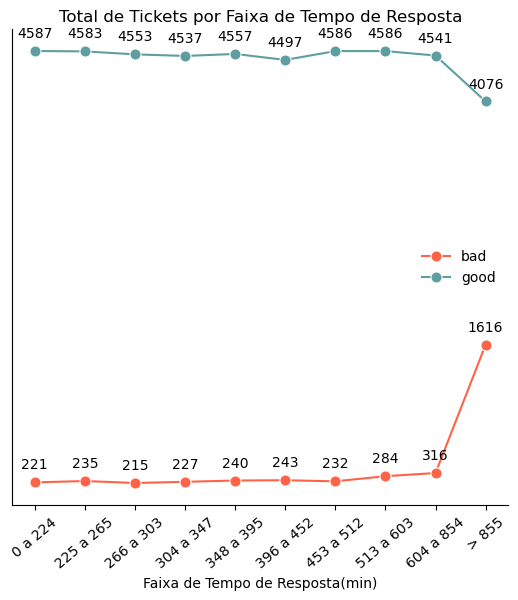

In [34]:
ax1 = sns.lineplot(data=count_pct_order_df, 
                   x='order_by_pct', 
                   y='count', 
                   hue='score', 
                   marker='o', 
                   markersize=8,
                  palette=['tomato', 'cadetblue'])

# Set labels and titles (be sure to specify which axis each label applies to)
ax1.set_ylabel("")
ax1.set_xlabel("Faixa de Tempo de Resposta(min)")
plt.title("Total de Tickets por Faixa de Tempo de Resposta")


# Set x-axis labels (as you did before)
labels = ['0 a 224','225 a 265','266 a 303','304 a 347','348 a 395','396 a 452','453 a 512','513 a 603',
'604 a 854','> 855']
ax1.set_xticklabels(labels,rotation=40)

for line in ax1.lines:  # Iterate through the lines (one for each hue)
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    for x, y in zip(x_data, y_data):
        ax1.annotate(f'{int(y)}', (x, y), textcoords="offset points", xytext=(0,10), ha='center') 

sns.despine()
plt.subplots_adjust(top=1.1)
plt.yticks(ticks=[])
plt.legend(frameon=False) #Show legend if needed
plt.show();

Neste gráfico podemos observar a tendêndia de crescimento dos tickets avaliados **negativamente** em relação ao tempo de resposta. Observamos o movimento contrário quando os tickets são avaliados **positivamente**

/var/folders/1x/vr_kl6dn0n18t95rvr6x3j4r0000gn/T/ipykernel_57824/2021401012.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels,rotation=40)


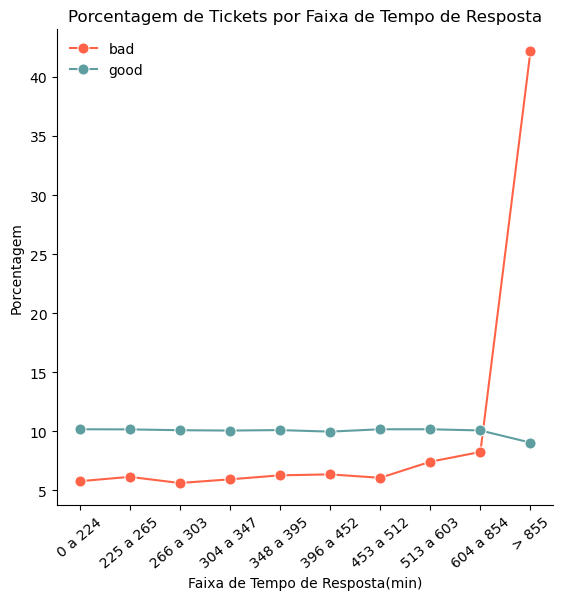

In [35]:
per_pct_order_df=with_time_data.groupby('score')['order_by_pct'].value_counts(
    normalize=True).reset_index().sort_values(by=['score','order_by_pct'])
per_pct_order_df['proportion']=np.round(per_pct_order_df['proportion']*100,2)

ax2 = sns.lineplot(data=per_pct_order_df, 
                   x='order_by_pct', 
                   y='proportion', 
                   hue='score', 
                   marker='o', 
                   markersize=8,
                  palette=['tomato', 'cadetblue'])

# Set labels and titles (be sure to specify which axis each label applies to)
ax2.set_ylabel("Porcentagem")
ax2.set_xlabel("Faixa de Tempo de Resposta(min)")
plt.title("Porcentagem de Tickets por Faixa de Tempo de Resposta")


# Set x-axis labels (as you did before)
labels = ['0 a 224','225 a 265','266 a 303','304 a 347','348 a 395','396 a 452','453 a 512','513 a 603',
'604 a 854','> 855']
ax2.set_xticklabels(labels,rotation=40)


sns.despine()
plt.subplots_adjust(top=1.1)
plt.legend(frameon=False) #Show legend if needed
plt.show();

Este mesmo gráfico utilizando as porcentagens nos mostra que mais de 40% dos tickets avaliados **negativamente** tem o seu tempo de resposta a partir de 600 minutos.

### Checking Quartils Visualization ###

In [36]:
quarters = [p / 100 for p in range(25, 100, 25)]

quarters_values=with_time_data['tempo_de_resposta'].quantile(quarters)
pd.DataFrame({'tempo_de_resposta': quarters_values}
            ).reset_index().rename(columns={'index':'quarter',
                                            'tempo_de_resposta':'quarter_value'})

,quarter,quarter_value
0,0.25,284.0
1,0.50,395.0
2,0.75,551.0


In [37]:
def classify_quartiles(value):
    if 0<=value<284:
        return '0 a 284'
    elif 285<=value<395:
        return '285 a 395'
    elif 396<=value<551:
        return '396 a 551'
    else:
        return'> 552'

In [38]:
with_time_data['quarter_range']=with_time_data['tempo_de_resposta'].apply(classify_quartiles)

In [39]:
with_time_data

,ticket_id,updated_at,score,tempo_de_resposta,more_3days,pct_range,order_by_pct,quarter_range
0,432437,2019-04-19 05:01:59,good,276,0,266 a 303,03,0 a 284
1,433524,2019-04-19 06:01:31,good,946,0,> 855,10,> 552
2,435257,2019-04-19 05:01:58,good,637,0,604 a 854,09,> 552
3,438204,2019-04-22 00:16:30,bad,5418,1,> 855,10,> 552
4,439172,2018-12-20 17:18:36,good,797,0,604 a 854,09,> 552
...,...,...,...,...,...,...,...,...
48927,768112,2020-03-17 13:53:29,good,177,0,0 a 224,01,0 a 284
48928,768118,2020-03-16 05:01:15,good,178,0,0 a 224,01,0 a 284
48929,768125,2020-03-16 06:01:17,good,221,0,0 a 224,01,0 a 284
48930,768127,2020-03-16 06:01:17,good,217,0,0 a 224,01,0 a 284


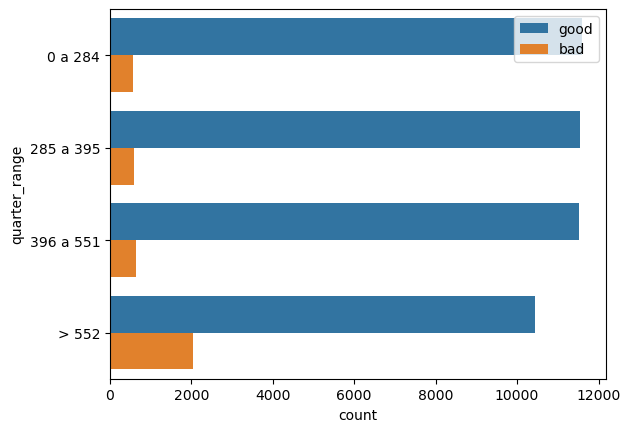

In [40]:
order=['0 a 284','285 a 395','396 a 551','> 552']

sns.countplot(data=with_time_data, 
              y='quarter_range', 
              hue='score',
              order=order
             )
plt.legend();


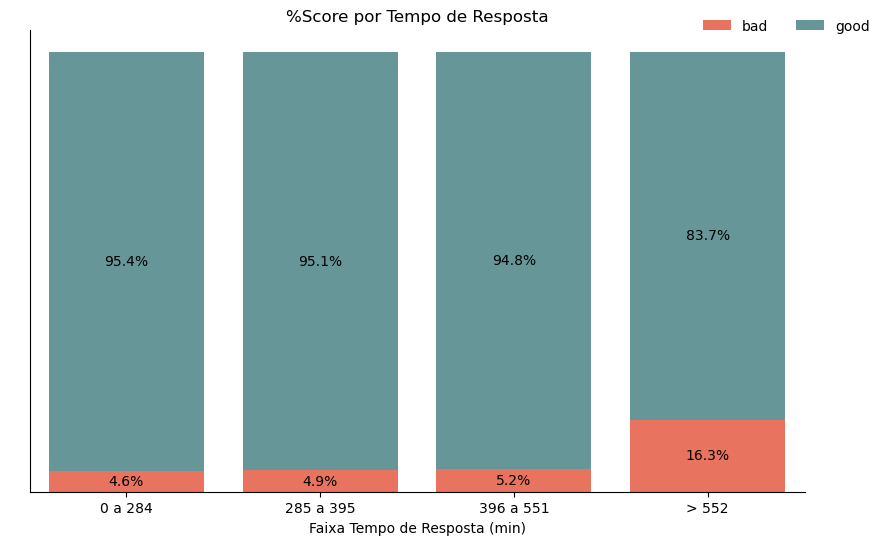

In [41]:
order=['0 a 284','285 a 395','396 a 551','> 552']

def calculate_percentages(df, x_col, hue_col, order):
    """Calculates percentages for stacked bar chart."""
    total_counts = df.groupby(x_col)[hue_col].count().reindex(order, fill_value=0) #Reindex to ensure correct order and 0 fill
    grouped_counts = df.groupby([x_col, hue_col]).size().unstack(fill_value=0).reindex(order, fill_value=0) #Reindex to ensure correct order and 0 fill
    percentages = (grouped_counts.T / total_counts).T * 100
    return percentages

percentages = calculate_percentages(with_time_data, 'quarter_range', 'score', order)

# 2. Create the stacked bar plot using sns.barplot:
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size if needed

bottom = None #Initialize for stacking
for hue_value, color in zip(['bad', 'good'], ['tomato', 'cadetblue']):
    sns.barplot(x=percentages.index, y=percentages[hue_value], color=color, ax=ax, label=hue_value, bottom=bottom)
    if bottom is None:
        bottom = percentages[hue_value]
    else:
        bottom += percentages[hue_value]

# 3. Add percentage labels above the stacked bars:
for p in ax.patches:
    height = p.get_height()
    if height > 0: #Avoid labels for 0 height bars.
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + height / 2  # Center vertically within the stack
        percentage = height #Height is already the percentage
        ax.text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black')  # Adjust color as needed

sns.despine()
plt.xlabel("Faixa Tempo de Resposta (min)") #Optional label
plt.ylabel(" ") #Optional label
plt.yticks(ticks=[])
plt.title("%Score por Tempo de Resposta") #Optional title
plt.legend(frameon=False, ncol=len(with_time_data.columns),bbox_to_anchor=(1.1, 1.05)) #Show legend if needed
plt.show()

Observamos o mesmo efeito do gráfico na seção anterior, porém em faixas com maior tempo em minutos

In [42]:
with_time_data['order_by_quarter']=pd.Series()
with_time_data['order_by_quarter']=np.where(with_time_data['quarter_range']=='0 a 284','1',with_time_data['order_by_quarter'])
with_time_data['order_by_quarter']=np.where(with_time_data['quarter_range']=='285 a 395','2',with_time_data['order_by_quarter'])
with_time_data['order_by_quarter']=np.where(with_time_data['quarter_range']=='396 a 551','3',with_time_data['order_by_quarter'])
with_time_data['order_by_quarter']=np.where(with_time_data['quarter_range']=='> 552','4',with_time_data['order_by_quarter'])

with_time_data=with_time_data.sort_values(by='order_by_quarter')


In [43]:
count_qtr_order_df=with_time_data.groupby('score')['order_by_quarter'].value_counts().reset_index().sort_values(by=['score','order_by_quarter'])

/var/folders/1x/vr_kl6dn0n18t95rvr6x3j4r0000gn/T/ipykernel_57824/363738192.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels,rotation=40)


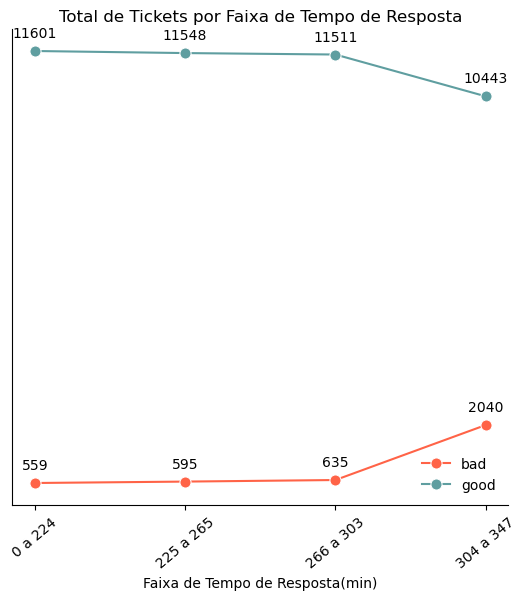

In [44]:
ax1 = sns.lineplot(data=count_qtr_order_df, 
                   x='order_by_quarter', 
                   y='count', 
                   hue='score', 
                   marker='o', 
                   markersize=8,
                  palette=['tomato', 'cadetblue'])

# Set labels and titles (be sure to specify which axis each label applies to)
ax1.set_ylabel("")
ax1.set_xlabel("Faixa de Tempo de Resposta(min)")
plt.title("Total de Tickets por Faixa de Tempo de Resposta")


# Set x-axis labels (as you did before)
labels = ['0 a 224','225 a 265','266 a 303','304 a 347','348 a 395','396 a 452','453 a 512','513 a 603',
'604 a 854','> 855']
ax1.set_xticklabels(labels,rotation=40)

for line in ax1.lines:  # Iterate through the lines (one for each hue)
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    for x, y in zip(x_data, y_data):
        ax1.annotate(f'{int(y)}', (x, y), textcoords="offset points", xytext=(0,10), ha='center') 

sns.despine()
plt.subplots_adjust(top=1.1)
plt.yticks(ticks=[])
plt.legend(frameon=False) #Show legend if needed
plt.show();

In [45]:
per_qtr_order_df=with_time_data.groupby('score')['order_by_quarter'].value_counts(
    normalize=True).reset_index().sort_values(by=['score','order_by_quarter'])
per_pct_order_df['proportion']=np.round(per_pct_order_df['proportion']*100,2)

/var/folders/1x/vr_kl6dn0n18t95rvr6x3j4r0000gn/T/ipykernel_57824/167004610.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels,rotation=40)


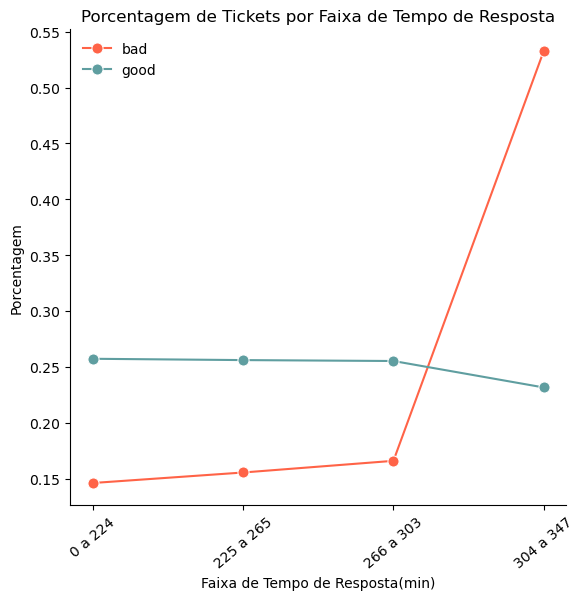

In [46]:
ax2 = sns.lineplot(data=per_qtr_order_df, 
                   x='order_by_quarter', 
                   y='proportion', 
                   hue='score', 
                   marker='o', 
                   markersize=8,
                  palette=['tomato', 'cadetblue'])

# Set labels and titles (be sure to specify which axis each label applies to)
ax2.set_ylabel("Porcentagem")
ax2.set_xlabel("Faixa de Tempo de Resposta(min)")
plt.title("Porcentagem de Tickets por Faixa de Tempo de Resposta")


# Set x-axis labels (as you did before)
labels = ['0 a 224','225 a 265','266 a 303','304 a 347','348 a 395','396 a 452','453 a 512','513 a 603',
'604 a 854','> 855']
ax2.set_xticklabels(labels,rotation=40)


sns.despine()
plt.subplots_adjust(top=1.1)
plt.legend(frameon=False) #Show legend if needed
plt.show();

### Validando a hipótese ####

A hipótese que temos é que o tempo de resposta do ticket maior faz com que as avaliações sejam negativas. Para validarmos estatísticamente esta hipótese conduziremos um teste de hipótese onde:

H0 a média do tempo de resposta é menor quando as avaliações são positivas

Isso nos permitirá compararmos as médias entre as duas amostras de ticket

In [47]:
from scipy import stats

In [48]:
with_time_data.groupby('score')['tempo_de_resposta'].describe()

,count,mean,std,min,25%,50%,75%,max
score,,,,,,,,
bad,3829.0,1049.890572,1038.144188,176.0,354.0,593.0,1489.0,10840.0
good,45103.0,465.806266,337.475504,176.0,281.0,387.0,530.0,11680.0


In [49]:
good= np.array(with_time_data.loc[
         with_time_data['score']=='good','tempo_de_resposta']
        )
bad=np.array(with_time_data.loc[
         with_time_data['score']=='bad','tempo_de_resposta']
        )

In [50]:
    stats.ttest_ind(a=good, b=bad, equal_var=False, alternative='greater')

TtestResult(statistic=-34.6594099645098, pvalue=1.0, df=3896.9647434959447)

O resultado do teste sugere que a média de tempo de resposta dos tickets avaliados como bom é significativamente menor do que a média dos tickets avaliados negativamente. Ou seja, há indicios de que o tempo de resposta menor impacta na avaliação positiva